In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import sys
sys.path.append('/home/maxf/projects/REFORM/src/grasp/data_handling/')
import prepare_obsdata_for_aspire as profa 
# Random number generator
rng = np.random.default_rng()

In [2]:
def calc_wind_mag_from_ds(ds):
    u = ds['u']
    v = ds['v']
    u = u.interp(xh=v.xf.values)
    v = v.interp(yh=u.yf.values)
    # Dims
    u = u.rename({'xh':'x', 'yf':'y'})
    v = v.rename({'xf':'x', 'yh':'y'})
    return np.sqrt(u**2 + v**2)


In [3]:
# Define directories
BASE_DIR       = "/home/maxf/projects/da4gs/esmda"
dir_base_sim   = f"{BASE_DIR}/runs/base_run/2020/04/04/00"
sims_directory = f"{BASE_DIR}/runs/run_esmda/2020/04/04/00"
data_directory = f"{BASE_DIR}/data/ensemble_data/2020/04/04/00"
obs_save_dir   = f"{BASE_DIR}/data/observation/synthetic_obs"

In [4]:
## DATA LOADING
ds_lidar = profa.load_cbw_lidar_data(date_init='20200404', date_end='20200405')
ds_lidar = ds_lidar.sel(time=slice(f"2020-04-04T20:00:10.000000000", f"2020-04-05T02:00:00.000000000"))
## Interpolate dataset to cabauw levels
levs = np.asarray([ 16.,  48.153847,  80.61688 , 113.39207, 146.4824,179.89095 , 213.62071 , 247.67484 , 282.0564  ])
ds_lidar = ds_lidar.interp(level=levs, method='linear',)
ds_lidar = ds_lidar.rename({'level': 'zf', 'ucbw': 'u', 'vcbw': 'v'})


# Load synthetic observations and IC field
# ds_synob     = xr.open_dataset((f'{obs_save_dir}/ds_obs_synthetic.nc'))
dir_synobs   = f"{BASE_DIR}/runs/run_esmda/2020/04/04/syn_obs"
# ds_synobs_IC = xr.open_dataset(f"{dir_synobs}/graspOutRestart.000.nc")


# Load reference model
ds_ref   = xr.open_dataset(f"{sims_directory}/graspOutSimdata.000.nc")
da_u_ref = ds_ref['u'].sel(zf=slice(0,300)).isel(xh=64, yf=64)
da_v_ref = ds_ref['v'].sel(zf=slice(0,300)).isel(xf=64, yh=64)
ds_refob = xr.Dataset({'u': da_u_ref, 'v': da_v_ref})

# Calc wind magnitude
# ds_synob['F'] = np.sqrt(ds_synob['u']**2 + ds_synob['v']**2)
ds_refob['F'] = np.sqrt(ds_refob['u']**2 + ds_refob['v']**2)
# Round time steps
# ds_synob['time'] = ds_synob['time'].dt.round('min')
ds_lidar['time'] = ds_lidar['time'].dt.round('min')
ds_refob['time'] = ds_refob['time'].dt.round('min')

Load cabauw data from 2020 04 to 2020 04


---
### Experiment Set-Up

- Show (synthetic) observations vs reference simulation
- Show ensemble creation

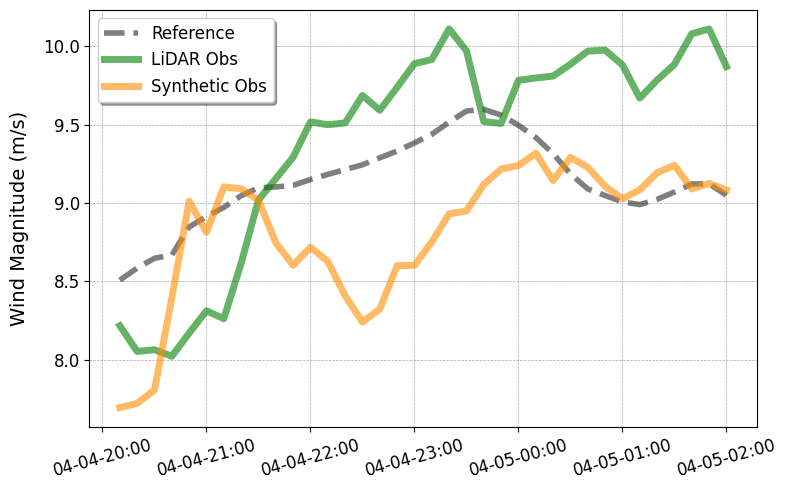

In [116]:
## Plot different observation and default model run
fig, ax = plt.subplots(figsize=(8, 5))

# Define x and y values for each realization
x_value = ds_lidar.time.values
y_lidar = ds_lidar['F'].mean(dim='zf').values
y_synob = ds_synob['F'].mean(dim='zf').values
y_refob = ds_refob['F'].mean(dim='zf').values

# Plot each time series with distinct colors and line styles
ax.plot(x_value, y_refob, label="Reference", color="k", linestyle="--", linewidth=4, alpha=0.5)
ax.plot(x_value, y_lidar, label="LiDAR Obs",     linewidth=5, alpha=0.6, color="green",)
ax.plot(x_value, y_synob, label="Synthetic Obs", linewidth=5, alpha=0.6, color="darkorange",) #linestyle="--"

# Set grid style for a clean, subtle background
ax.grid(visible=True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Label axes with larger font sizes
ax.set_ylabel("Wind Magnitude (m/s)", fontsize=14, labelpad=10)

# Format x-axis for datetime
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%H:%M"))
ax.tick_params(axis="x", rotation=15)  # Rotate dates for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Add legend with frame and adjust for clarity
ax.legend(frameon=True, loc="best", fontsize=12, shadow=True)

# Final layout adjustments
plt.tight_layout()
plt.show()


In [101]:
#------------------------------------------
# Show IC fields
#---------------
da_M_ic_synobs = calc_wind_mag_from_ds(ds_synobs_IC)
da_M_ic_ref    = calc_wind_mag_from_ds(ds_ref.isel(time=0))

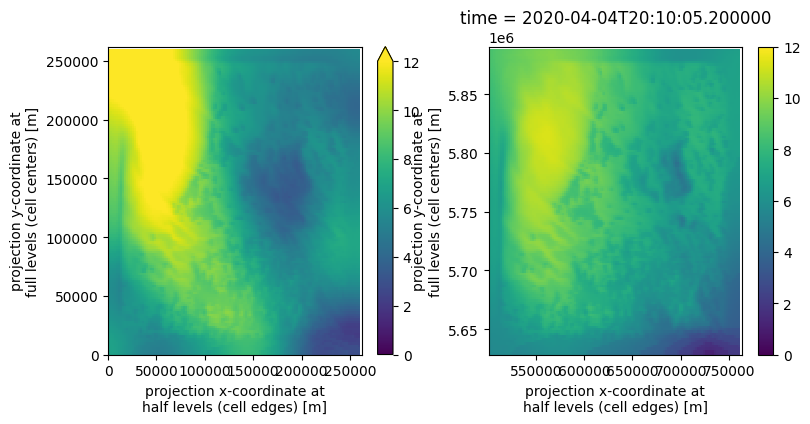

In [107]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4))

da_M_ic_synobs.sel(zf=slice(0,300)).mean(dim='zf').plot(ax=ax[0], vmax=12, vmin=0)
da_M_ic_ref.sel(zf=slice(0,300)).mean(dim='zf').plot(ax=ax[1], vmax=12, vmin=0)

---
---
# Results

In [5]:
import glob
def calc_wind_mag(ds):
    ne = len(list(ds.data_vars)) // 2 
    assert len(list(ds.data_vars)) % 2 == 0, "Weird number of data-arrays, check input ds"
    for i in range(ne):
        ds[f'M_memb{i}'] = np.sqrt(ds[f'u_memb{i}']**2 + ds[f'v_memb{i}']**2)
    return ds

def load_assimilation_step(step, data_dir, data='data'):
    
    if data=='data':
        if step=='posterior':
            print("Loading data posterior")
            dirs = sorted(glob.glob(f"{data_dir}/data_posterior_step*_member*.nc"))
        else:
            print(f"Loading data at step {step}")
            dirs = sorted(glob.glob(f"{data_dir}/data_prior_step{str(step).zfill(2)}_member*.nc"))
    elif data=='model':
        print(f"Loading model at step {step}")
        dirs = sorted(glob.glob(f"{data_dir}/model_post_step{str(step).zfill(2)}_member*.nc"))       
    
    ds_all = xr.Dataset()
    for i,dir in enumerate(dirs):
        ds = xr.open_dataset(dir)
        # Round time to minutes
        if data=='data':
            ds['time'] = ds['time'].dt.round('min')
            ds_all[f'u_memb{i}'] = ds['u_predobs']
            ds_all[f'v_memb{i}'] = ds['v_predobs']
        else:
            ds_all[f'u_memb{i}'] = ds['u']
            ds_all[f'v_memb{i}'] = ds['v']
    
    return ds_all
def compute_ens_mean(ds):
    u_mean, v_mean, M_mean = 0, 0, 0
    idx_x, idx_y, idx_M = 0, 0, 0
    
    for i, var in enumerate(ds.data_vars):
        da = ds[var]
        if 'time' in ds.sizes:
            da['time'] = da['time'].dt.round('min')
        if 'u' in var:
            u_mean += da
            idx_x += 1
        elif 'v' in var:
            v_mean += da
            idx_y += 1
        elif 'M' in var:
            M_mean += da
            idx_M += 1
        else:
            print(f"Different DataArray {var}")
    
    assert idx_x == idx_y, "Not same amount of u and v variables"
    assert idx_x != 0, "DataSet contains no variables u or v!"
    u_mean /= idx_x
    v_mean /= idx_y

    if idx_M != 0:
        M_mean /= idx_M
    
    ds_mean = xr.Dataset({
        'u_mean': u_mean,
        'v_mean': v_mean,
        'M_mean': M_mean,
        })
    return ds_mean

In [6]:
##------------------------------------------------------
## Load observtions
##-----------

EXPERIMENT_NAME = "ESMDA_ne15_a4_synthetic"

BASE_DIR     = "/home/maxf/projects/da4gs/esmda"
dir_base_sim = f"{BASE_DIR}/runs/base_run/2020/04/04/00"
obs_save_dir = f"{BASE_DIR}/data/observation/synthetic_obs"
data_dir = f"/home/maxf/projects/da4gs/esmda/data/esmda_fields/{EXPERIMENT_NAME}"
# ds_synth_obs = xr.open_dataset(f"{obs_save_dir}/ds_obs_synthetic.nc")
# grasp_levels = ds_synth_obs.zf.values
grasp_levels = np.asarray([ 16.,  48.153847,  80.61688 , 113.39207, 146.4824,179.89095 , 213.62071 , 247.67484 , 282.0564  ])
ds_restart_base = xr.open_dataset(f'{dir_base_sim}/graspOutRestart.000.nc')


## Load LiDAR data and interpolate dataset to grasp-meso levels
ds_lidar = profa.load_cbw_lidar_data(date_init='20200404', date_end='20200405')
ds_lidar = ds_lidar.sel(time=slice(f"2020-04-04T20:00:10.000000000", f"2020-04-05T02:00:00.000000000"))
ds_lidar = ds_lidar.interp(level=grasp_levels, method='linear',)
ds_lidar = ds_lidar.rename({'level': 'zf', 'ucbw': 'u', 'vcbw': 'v', 'F':'M'})


Load cabauw data from 2020 04 to 2020 04


In [7]:
# Process data assiimilation data
ds_prior     = load_assimilation_step(step=0, data_dir=data_dir)
ds_posterior = load_assimilation_step(step='posterior', data_dir=data_dir)
ds_prior     = calc_wind_mag(ds=ds_prior)
ds_posterior = calc_wind_mag(ds=ds_posterior)
ds_prior_mean     = compute_ens_mean(ds_prior)
ds_posterior_mean = compute_ens_mean(ds_posterior)


# Process data assiimilation model
ds_model_step0 = load_assimilation_step(step=0, data_dir=data_dir, data='model')
ds_model_post  = load_assimilation_step(step=3, data_dir=data_dir, data='model')
ds_model_prior_mean = compute_ens_mean(ds_model_step0)
ds_model_post_mean  = compute_ens_mean(ds_model_post)

# Change dataset datasets
ds_posterior_mean = ds_posterior_mean.rename({'u_mean':'u', 'v_mean':'v', 'M_mean':'M'})
ds_prior_mean = ds_prior_mean.rename({'u_mean':'u', 'v_mean':'v', 'M_mean':'M'})



Loading data at step 0
Loading data posterior
Loading model at step 0
Loading model at step 3


In [9]:
dir_synobs = f"{BASE_DIR}/runs/run_esmda/2020/04/04/syn_obs"
ds_simdat_synob = xr.open_dataset(f"{dir_synobs}/graspOutSimdata.000.nc")
da_u_synob = ds_simdat_synob['u'].sel(zf=slice(0,300)).isel(xh=64, yf=64)
da_v_synob = ds_simdat_synob['v'].sel(zf=slice(0,300)).isel(xf=64, yh=64)

## Add noise to create noisy observations
dstd = np.ones(da_u_synob.shape) * 0.2
da_u_synob_noisy = da_u_synob + np.random.normal(0, dstd , size=da_u_synob.shape)
da_v_synob_noisy = da_v_synob + np.random.normal(0, dstd , size=da_v_synob.shape)
ds_synob = xr.Dataset({
    'u': da_u_synob_noisy,
    'v': da_v_synob_noisy
    })

In [11]:
ds_synob['M'] = np.sqrt(ds_synob['u']**2 + ds_synob['v']**2)

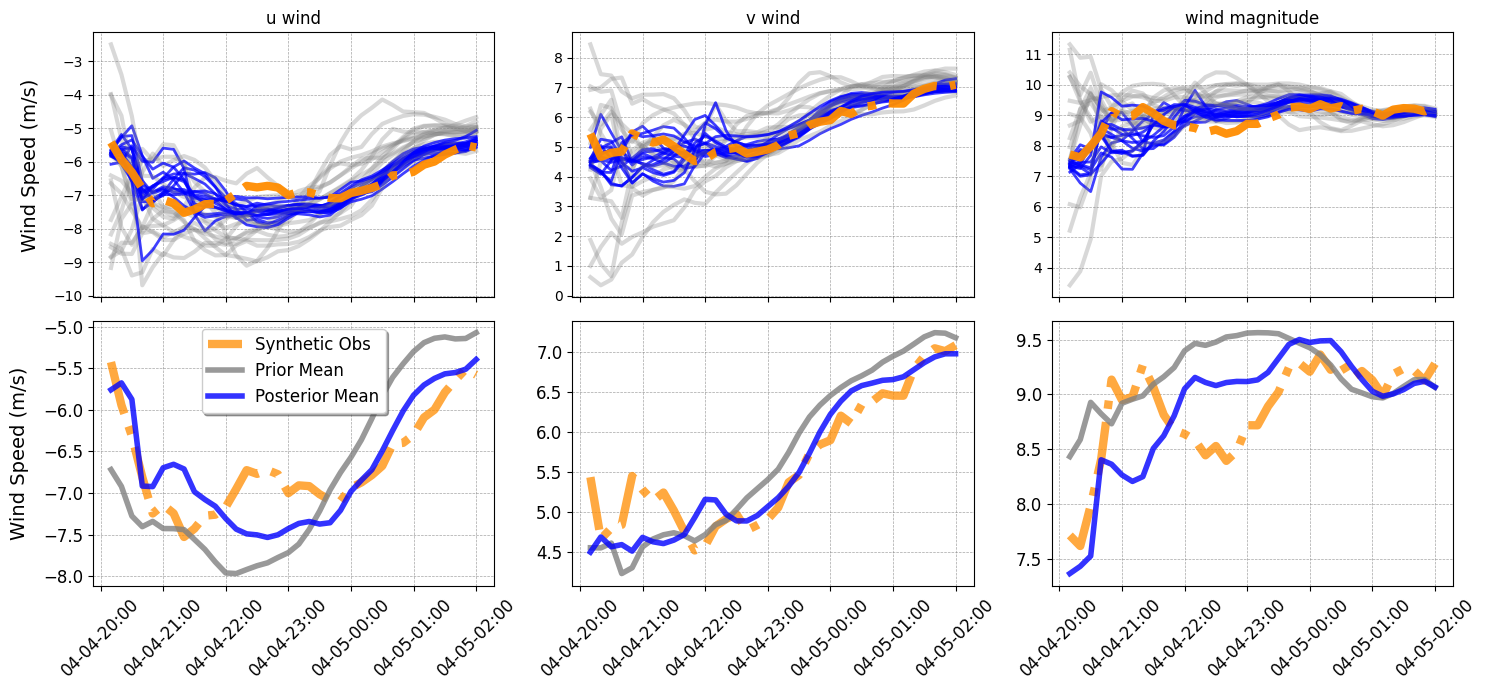

In [12]:
## Plot different observation and default model run
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 7), sharex=True)

ax = axs.flatten()
# Define x and y values for each realization

ens_data_list  = [ds_synob, ds_prior     , ds_posterior]
mean_data_list = [ds_synob, ds_prior_mean, ds_posterior_mean]
label_list  = ['Synthetic Obs', 'Prior Mean', 'Posterior Mean']

plt_settings = [{'lw': 6, 'alpha': 0.75, 'color': 'darkorange', 'ls':'-.'}, 
                {'lw': 4, 'alpha': 0.8, 'color': 'gray', 'ls':'-'},
                {'lw': 4, 'alpha': 0.8, 'color': 'blue'  , 'ls':'-'},
                ]


# zf_vals = ds_prior_mean.zf.values
# ax[1].set_title(f"Avg over levs: {np.round(zf_vals)}")


var_list = ['u', 'v', 'M']
ens_vars = ['u_memb', 'v_memb', 'M_memb']

title_list = ['u wind', 'v wind', 'wind magnitude']

x_data = ds_lidar.time.values

# Loop over all panels
for i in range(axs.shape[1]):
    # loop over all datasets
    for j in range(3):
        # Data
        y_data = mean_data_list[j][var_list[i]].mean(dim='zf').values
        # Plot settings
        lw = plt_settings[j].get('lw')
        ls = plt_settings[j].get('ls')
        alpha = plt_settings[j].get('alpha')
        color = plt_settings[j].get('color')
        # Plot
        ax[i+3].plot(x_data, y_data, label=label_list[j], linewidth=lw, linestyle=ls, alpha=alpha, color=color)

        if 'synthetic' in label_list[j].lower():
            ax[i].plot(x_data, y_data, label=label_list[j], linewidth=lw, linestyle=ls, alpha=alpha+0.2, color=color, zorder=5)


    # Plot prior ensemble for u,v and M

    for idx, var in enumerate(ds_prior.data_vars):
        if var_list[i] in var:        
            y_data_prior = ds_prior[var].mean(dim='zf').values
            ax[i].plot(x_data, y_data_prior, color='grey', linewidth=3, alpha=0.3)
            y_data_post = ds_posterior[var].mean(dim='zf')
            ax[i].plot(x_data, y_data_post, color='blue', linewidth=2, alpha=0.75)


    # Set grid style for a clean, subtle background
    ax[i].grid(visible=True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax[i+3].grid(visible=True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Format x-axis for datetime
    ax[i+3].xaxis.set_major_formatter(mdates.DateFormatter("%m-%d-%H:%M"))
    ax[i+3].tick_params(axis="x", rotation=45)  # Rotate dates for readability
    ax[i+3].tick_params(axis='both', which='major', labelsize=12)

    ax[i].set_title(title_list[i])
    # ax[i+3].set_title("")

# Label axes with larger font sizes
# Add legend with frame and adjust for clarity
ax[0].set_ylabel("Wind Speed (m/s)", fontsize=14, labelpad=10)
ax[3].set_ylabel("Wind Speed (m/s)", fontsize=14, labelpad=10)
ax[3].legend(frameon=True, loc="best", fontsize=12, shadow=True)

# Final layout adjustments
plt.tight_layout()
plt.show()



In [19]:
## Round time
ds_synob['time'] = ds_synob['time'].dt.round('min')
ds_prior_mean['time'] = ds_prior_mean['time'].dt.round('min')
ds_posterior_mean['time'] = ds_posterior_mean['time'].dt.round('min')

da_u_prior_bias = ds_prior_mean['u'] - ds_synob['u']
da_v_prior_bias = ds_prior_mean['v'] - ds_synob['v']
da_M_prior_bias = ds_prior_mean['M'] - ds_synob['M']


da_u_post_bias = ds_posterior_mean['u'] - ds_synob['u']
da_v_post_bias = ds_posterior_mean['v'] - ds_synob['v']
da_M_post_bias = ds_posterior_mean['M'] - ds_synob['M']

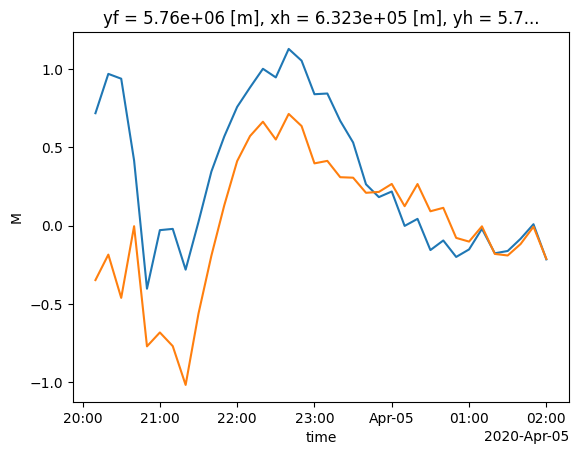

In [20]:
da_M_prior_bias.mean(dim='zf').plot()
da_M_post_bias.mean(dim='zf').plot()